***
<center><font color="dodgerblue"><font size="7"><b><i>Analyse de Données Développeur<br />(C5-160512-INFO)</i></b></font></font></center>

***

<center><font color="darkorange"><font size="8"><b><i>4) Apprentissage Non Supervisé (TP #2) <br/><font size="6">&copy C. Frélicot, Automne 2023</font></i></b></font></font></center>

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import warnings
warnings.filterwarnings('ignore')

***
# 1)  Tableau de données (du TD)
***
## Lecture de fichier formatté à l'aide de *Pandas*.

In [2]:
df = pd.read_excel("MLlogiciel.xls",sheet_name='Feuille1',index_col=0)
row_label = df.index.values 
col_label = df.columns.values
logiciel = df['ML'].values
X = df.select_dtypes(include='number').values
n, p = np.shape(X)
df

,S,A,A+,ML
x,3,13,17,Green
y,12,6,11,Yellow
z,10,14,20,Green
t,1,14,2,Blue
u,7,15,9,Blue


## Copiez ici vos fonctions python *dist*, *prototyping*, *clustering*, *kmeans* et *standardize* des TPs précédents.

In [3]:
def dist(x,y,dname='euclidean'):
    if dname == 'manhattan':
        d = np.sum(np.abs(x-y))
    elif dname == 'euclidean':
        d = np.sqrt(np.sum((x-y)**2))
    elif dname == 'chebyshev':
        d = np.max(np.abs(x-y))
    elif dname == 'cosine':
        d = 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    elif dname == 'correlation':
        d = 1 - np.dot(x-np.mean(x),y-np.mean(y))/(np.linalg.norm(x-np.mean(x))*np.linalg.norm(y-np.mean(y)))
    
    return d

def prototyping(data,indicator):
        
    unique = np.unique(indicator)
    barycentres = {}
    
    for cluster in unique:
        cluster_points = data[np.array(indicator) == cluster]
        barycentres[cluster] = np.mean(cluster_points,axis=0)
        
    return barycentres

def clustering(data,centroids,dname='euclidean'):

    clusters = []
    distances_to_centroids = []
    
    for point in data:
        distances = {cluster:dist(point,centroid,dname) for cluster,centroid in centroids.items()}
        closest = min(distances,key=distances.get)
        clusters.append(closest)
        distances_to_centroids.append(distances[closest])
        
    return clusters, distances_to_centroids

def kmeans(data,clust_nb,maxiter=10,eps=0.01,dname='euclidean'):

    np.random.seed(42)
    centroids = { i + 1 : data[idx] for i, idx in enumerate(np.random.choice(data.shape[0], clust_nb, replace = False))}
    
    for t in range(maxiter):
        
        indicator, _ = clustering(data,centroids,dname)
        new_centroids = prototyping(data,indicator)
        
        max_shift = max(np.linalg.norm(new_centroids[c] - centroids[c]) for c in centroids)
        centroids = new_centroids
        
        if max_shift < eps:
            break

    return indicator, centroids

def standardize(data,scale=False):
    
    data_p = data - np.mean(data, axis=0)
    if scale:
        data_s = data_p / np.std(data_p, axis=0)
        transformed_data = data_s
    else:
        transformed_data = data_p
    
    cov_data = np.cov(transformed_data.T)
    
    return transformed_data, cov_data

## Verifiez qu'elles sont justes en appliquant les *kmeans* sur le tableau $X$.

In [5]:
Y, centroids = kmeans(X,3)

print(Y)

[3, 1, 3, 2, 2]


***
# 2) Inerties de Partition
***

## 2-1) Trouvez comment calculer l'inertie totale $I_V = trace(V)$, sans calculer $V$, avec une seule exécution de votre fonction *kmeans*.

In [6]:
Y, centroids = kmeans(X,3)

Iv = 0
for i in range(n):
    Iv += dist(X[i],centroids[Y[i]])**2
print(Iv)

72.5


## Sans regarder les valeurs du tableau des *centroids*, pouvez-vous dire ce qu'il contient ? 

In [7]:
print(centroids)

{1: array([12.,  6., 11.]), 2: array([ 4. , 14.5,  5.5]), 3: array([ 6.5, 13.5, 18.5])}


## 2-2) Pensez-vous pouvoir retrouver les résultats de calcul des inerties intra-clusters $I_w$ et inter-clusters $I_b$ sans calculer aucune matrice de covariance ($V$, $B$, $W$) ?

In [8]:
Iw = 0
for i in range(n):
    Iw += dist(X[i],centroids[Y[i]])**2
    
Ib = 0
for i in range(n):
    Ib += dist(centroids[Y[i]],centroids[Y[i]])**2
    
print(Iw,Ib)

72.5 0.0


***
# 3) Evaluation d'une partition : Indice de Dunn 
***

## Import et exécution de fonctions utiles que vous pourriez coder si le temps n'était pas compté... Comprenez leur usage.

In [9]:
from scipy.spatial.distance import squareform, pdist
print(pdist(X)**2)
print(squareform(pdist(X))**2)
print(squareform(squareform(pdist(X))**2))

[166.  59. 230.  84. 149. 266. 110. 405. 131.  86.]
[[  0. 166.  59. 230.  84.]
 [166.   0. 149. 266. 110.]
 [ 59. 149.   0. 405. 131.]
 [230. 266. 405.   0.  86.]
 [ 84. 110. 131.  86.   0.]]
[166.  59. 230.  84. 149. 266. 110. 405. 131.  86.]


In [10]:
from sklearn.metrics import pairwise_distances
pairwise_distances(X.T,metric='cosine')

array([[0.        , 0.25861379, 0.13970939],
       [0.25861379, 0.        , 0.14891011],
       [0.13970939, 0.14891011, 0.        ]])

## 3-2) Ecrivez une fonction permettant de calculer l'indice de Dunn d'une partition. Retrouvez les résultats du TD.

In [11]:
Y1 = [1,2,3,1,1]
Y2 = [3,2,2,1,1]
Y3 = [3,2,3,1,1]
Yp = [1,1,1,2,2]

In [20]:
def dunnindex(data, indicator, dname='euclidean'):
    """
    Calcule l'indice de Dunn pour évaluer la qualité d'une partition.

    Paramètres:
        data (numpy.ndarray): Tableau des données (n individus x p variables).
        indicator (array-like): Indicatrice de partition (taille n).
        dname (str): Nom de la distance ('euclidean' par défaut).

    Retourne:
        float: Valeur de l'indice de Dunn.
    """
    unique_clusters = np.unique(indicator)
    inter_cluster_distances = []
    intra_cluster_diameters = []

    # Calcul des barycentres
    centroids = prototyping(data, indicator)

    # Distances inter-clusters
    for i in unique_clusters:
        for j in unique_clusters:
            if i < j:
                distance = dist(centroids[i], centroids[j])
                inter_cluster_distances.append(distance)

    # Diamètres intra-clusters
    for cluster in unique_clusters:
        cluster_points = data[np.array(indicator) == cluster]
        max_distance = max(
            dist(cluster_points[i], cluster_points[j])
            for i in range(len(cluster_points))
            for j in range(len(cluster_points))
        )
        intra_cluster_diameters.append(max_distance)

    # Calcul de l'indice de Dunn
    DI = min(inter_cluster_distances) / max(intra_cluster_diameters)

    return DI

In [21]:
dunnindex(X,Y3)

1.2883647468516952

In [22]:
dunnindex(X,Y2)

0.7106571304412417

In [23]:
dunnindex(X,Y1)

0.7695911456097753

In [24]:
dunnindex(X,Yp)

0.9225350673381151

***
# 4) Comparaison de deux partitions : Indice de Rand
***

## 4-1) Comprenez ce que fait la fonction ci-dessous, puis testez-la de sorte de retrouver les résultats du TD.

In [25]:
def partitionmatrix(indicator):
    data_nb = len(indicator)
    clust_id = np.unique(indicator)
    clust_nb = len(clust_id)
    data_partition = np.zeros((data_nb,clust_nb))
    for k in range(n):
        data_partition[k,clust_id==indicator[k]] = 1
    return data_partition

## 4-2) Ecrivez une fonction *randindex* permettant de calculer l'indice de Rand entre deux partitions définies par leur matrice de partition stricte. Retrouvez les résultats du TD. 

In [27]:
def randindex(Y1, Y2):
    """
    Calcule l'indice de Rand pour mesurer la similarité entre deux partitions.

    Paramètres:
        Y1 (array-like): Première partition (indicatrice).
        Y2 (array-like): Deuxième partition (indicatrice).

    Retourne:
        float: Indice de Rand.
    """
    if len(Y1) != len(Y2):
        raise ValueError("Les deux partitions doivent avoir la même taille.")

    n = len(Y1)
    a = b = 0

    for i in range(n):
        for j in range(i + 1, n):
            same_cluster_Y1 = (Y1[i] == Y1[j])
            same_cluster_Y2 = (Y2[i] == Y2[j])

            if same_cluster_Y1 and same_cluster_Y2:
                a += 1
            elif not same_cluster_Y1 and not same_cluster_Y2:
                b += 1

    RI = 2 * (a + b) / (n * (n - 1))
    return RI

In [28]:
randindex(Y3,Yp)

0.8

In [29]:
randindex(Yp,Y1)

0.5

***
# 5) Clustering de composants chimiques de vins italiens
## Données Réelles : 13 mesures sur 178 vins de 3 viticulteurs différents provenant de la même région https://archive.ics.uci.edu/ml/datasets/wine
***

## Lecture des données.

In [30]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
Y_true = data.target
n, p = np.shape(X)

## En combien de clusters auriez-vous envie de partitionner ces données ?

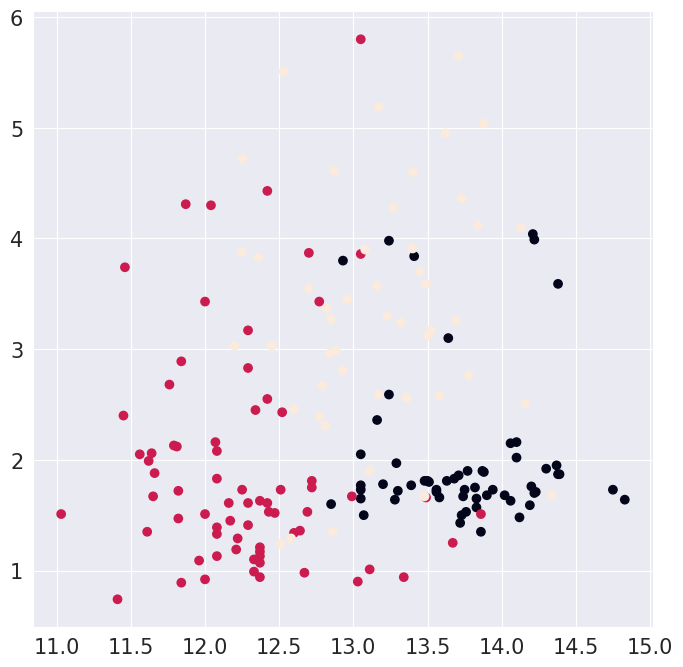

In [32]:
plt.figure(figsize=(8,8))
fontsize=15
plt.scatter(X[:,0],X[:,1],c=Y_true)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.show()

## 5-1) A l'aide d'une boucle sur un nombre de clusters par exemple dans $[2,c_{max}=10]$, calculez les valeurs de l'Indice de Dunn des partitions finales. Vous pouvez initialisze une liste vide et utiliser un *.append*

In [33]:
n_clusters = range(2,11)
Dunn = []
for k in n_clusters:
    Y, _ = kmeans(X,k)
    Dunn.append(dunnindex(X,Y))
    
print(Dunn)

[0.7233395982149058, 0.38073088351625634, 0.5837694095673293, 0.4218948644777425, 0.744120400381586, 0.5904623065435411, 0.40867854170486806, 0.3364008240483007, 0.19345385858898417]


## Affichez la courbe de l'Indice de Dunn en fonction du nombre de clusters, puis choisissez le nombre otimal de clusters pour ces données

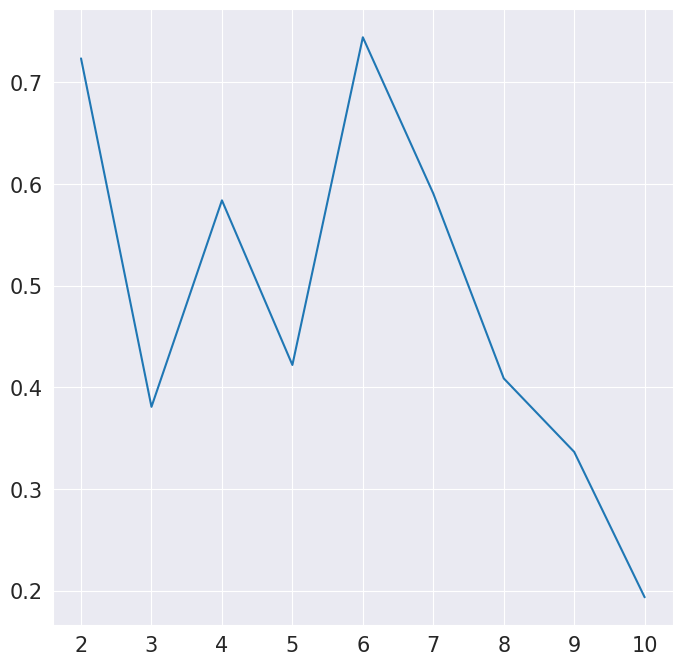

In [34]:
plt.figure(figsize=(8,8))
fontsize=15
plt.plot(n_clusters,Dunn)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.show()

## Que pensez-vous du résultat ?

## Essayez avec une autre distance.

## 5-2) Modifiez le code précédent de sorte de calculer l'Indice de Dunn de la meilleure partition (au sens de l'inertie intra-clusters) pour plusieurs exécutions des *kmeans* (par ex. 10 ou 20).

In [35]:
n_clusters = range(2,11)
Dunn = []
for k in n_clusters:
    Dunn_k = []
    for i in range(20):
        Y, _ = kmeans(X,k)
        Dunn_k.append(dunnindex(X,Y))
    Dunn.append(max(Dunn_k))
    
print(Dunn)

[0.7233395982149058, 0.38073088351625634, 0.5837694095673293, 0.4218948644777425, 0.744120400381586, 0.5904623065435411, 0.40867854170486806, 0.3364008240483007, 0.19345385858898417]


## Recopiez ici le code d'affichage de la courbe et exécutez-le.

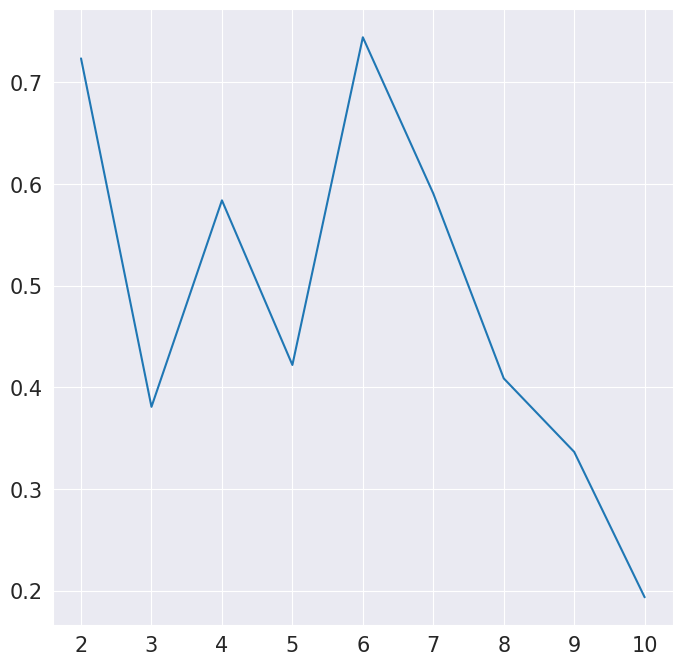

In [36]:
plt.figure(figsize=(8,8))
fontsize=15
plt.plot(n_clusters,Dunn)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.show()

## 5.3) A l'aide de boucles sur un nombre de clusters variant par ex. de 2 à 5 ou 10, comparez toutes les partitions deux à deux avec le Rand Index

In [37]:
n_clusters = range(2,6)
RI = np.zeros((len(n_clusters),len(n_clusters)))
for i,k1 in enumerate(n_clusters):
    for j,k2 in enumerate(n_clusters):
        Y1, _ = kmeans(X,k1)
        Y2, _ = kmeans(X,k2)
        RI[i,j] = randindex(Y1,Y2)
        
print(RI)

[[1.         0.71218181 0.69116994 0.63905288]
 [0.71218181 1.         0.94128103 0.83545991]
 [0.69116994 0.94128103 1.         0.87081826]
 [0.63905288 0.83545991 0.87081826 1.        ]]


In [38]:
RI = np.zeros((len(n_clusters),len(n_clusters)))
for i,k1 in enumerate(n_clusters):
    for j,k2 in enumerate(n_clusters):
        Y1, _ = kmeans(X,k1)
        Y2, _ = kmeans(X,k2)
        RI[i,j] = randindex(Y1,Y2)
        
print(RI)

[[1.         0.71218181 0.69116994 0.63905288]
 [0.71218181 1.         0.94128103 0.83545991]
 [0.69116994 0.94128103 1.         0.87081826]
 [0.63905288 0.83545991 0.87081826 1.        ]]


## Ci-dessous, un affichage *heatmap* des résultats. Avez-vous des commentaires ?

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '2'), Text(0, 1.5, '3'), Text(0, 2.5, '4'), Text(0, 3.5, '5')])

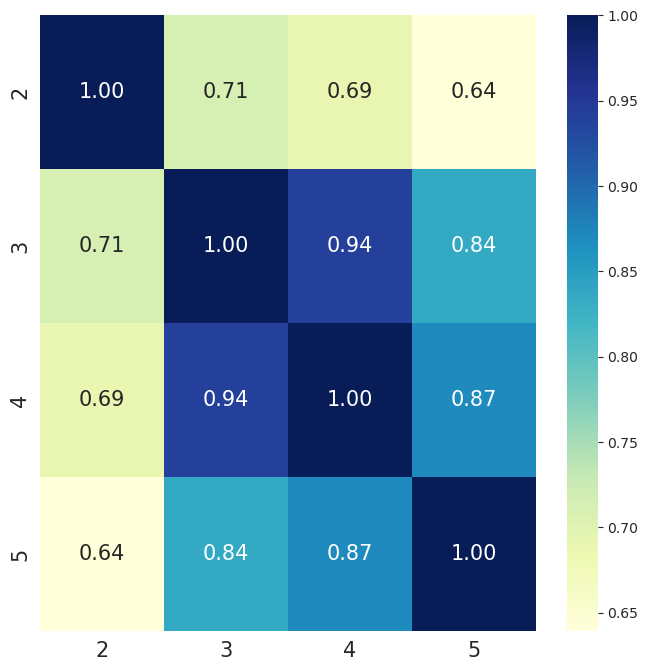

In [39]:
import seaborn as sb
plt.figure(figsize=(8,8))
fontsize=15
sb.heatmap(RI,annot=True,xticklabels=n_clusters,yticklabels=n_clusters,
           cmap="YlGnBu",
           annot_kws={"size": fontsize},
           fmt='.2f',cbar=True)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

## Recommencez en changeant de distance.

[[1.         0.68037834 0.71110265 0.635498  ]
 [0.68037834 1.         0.80905224 0.79984765]
 [0.71110265 0.80905224 1.         0.82371612]
 [0.635498   0.79984765 0.82371612 1.        ]]


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '2'), Text(0, 1.5, '3'), Text(0, 2.5, '4'), Text(0, 3.5, '5')])

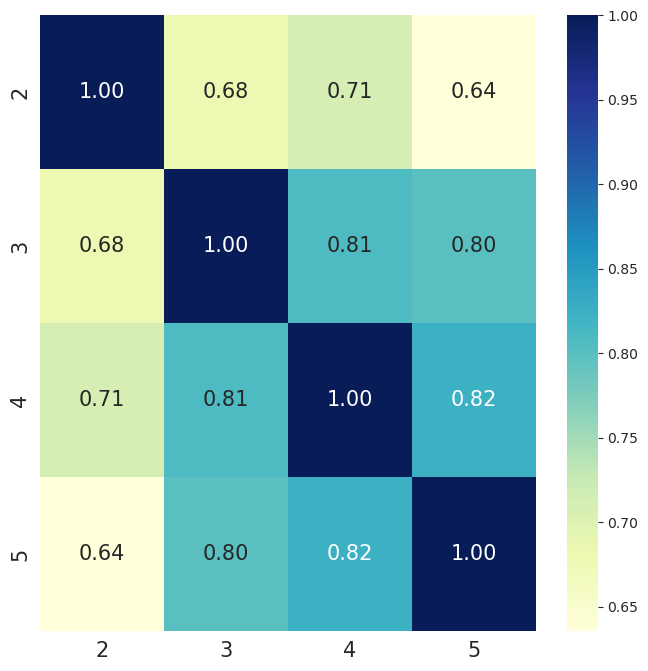

In [40]:
RI = np.zeros((len(n_clusters),len(n_clusters)))
for i,k1 in enumerate(n_clusters):
    for j,k2 in enumerate(n_clusters):
        Y1, _ = kmeans(X,k1,dname='cosine')
        Y2, _ = kmeans(X,k2,dname='cosine')
        RI[i,j] = randindex(Y1,Y2)
        
print(RI)

plt.figure(figsize=(8,8))
fontsize=15
sb.heatmap(RI,annot=True,xticklabels=n_clusters,yticklabels=n_clusters,
           cmap="YlGnBu",
           annot_kws={"size": fontsize},
           fmt='.2f',cbar=True)

plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)